# Correlation & Visualization Analysis

This notebook explores how polypropylene (PP) prices correlate with crude oil (Brent & WTI) and natural gas prices.

**Goals**
1. Load the processed dataset.
2. Inspect data quality and trends.
3. Compute pairwise correlations.
4. Visualize relationships (line plots, scatter plots, heatmap).

## 1. Load and Inspect the Processed Dataset
We start by importing the necessary Python libraries and loading the cleaned monthly dataset that combines
polypropylene (PP), Brent oil, WTI oil, and natural gas prices.  
This dataset was created in the preprocessing stage and saved as `master_monthly_prices.csv`.


In [9]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = Path.cwd()
if BASE_DIR.name == 'notebooks':
    BASE_DIR = BASE_DIR.parent

# Load processed dataset
data_path = BASE_DIR / 'data' / 'processed' / 'master_monthly_prices.csv'

df = pd.read_csv(data_path, parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Preview
print(df.head())
PLOTS = BASE_DIR / 'plots'
PLOTS.mkdir(parents=True, exist_ok=True)

             PP_EU  Brent    WTI  NatGas
Date                                    
2019-01-31  1385.0  59.77  51.07    3.15
2019-02-28  1385.0  63.63  54.53    2.69
2019-03-31  1410.0  66.66  57.62    2.83
2019-04-30  1430.0  71.03  63.22    2.62
2019-05-31  1430.0  70.93  61.76    2.60


## 2. Data Quality and Initial Trend Visualization
Before analyzing relationships, we check for missing values and visualize all variables together to understand
their overall movement since 2019.  
Because PP prices are in EUR per ton and oil/gas are in USD per barrel or MMBtu, they have different scales.


Missing values:
 PP_EU     0
Brent     0
WTI       0
NatGas    0
dtype: int64

Date range: 2019-01-31 00:00:00 → 2025-10-31 00:00:00


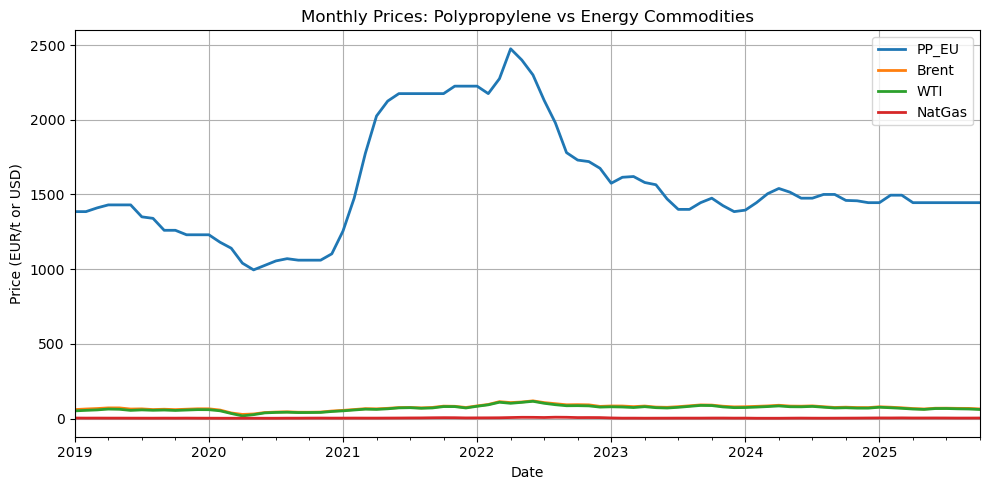

In [10]:
print("Missing values:\n", df.isna().sum())
print("\nDate range:", df.index.min(), "→", df.index.max())

# Quick line plot of all variables
df.plot(figsize=(10,5), linewidth=2)
plt.title("Monthly Prices: Polypropylene vs Energy Commodities")
plt.ylabel("Price (EUR/t or USD)")
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOTS / 'corr_prices_lines.png', dpi=150, bbox_inches='tight')
plt.show()


## 3. Normalized Trend Comparison
Because Polypropylene prices (in EUR/t) are much higher than crude oil and natural gas prices (in USD),
the energy price movements appear flat in the original plot.  
To compare relative movements, we normalize all variables between 0 and 1.


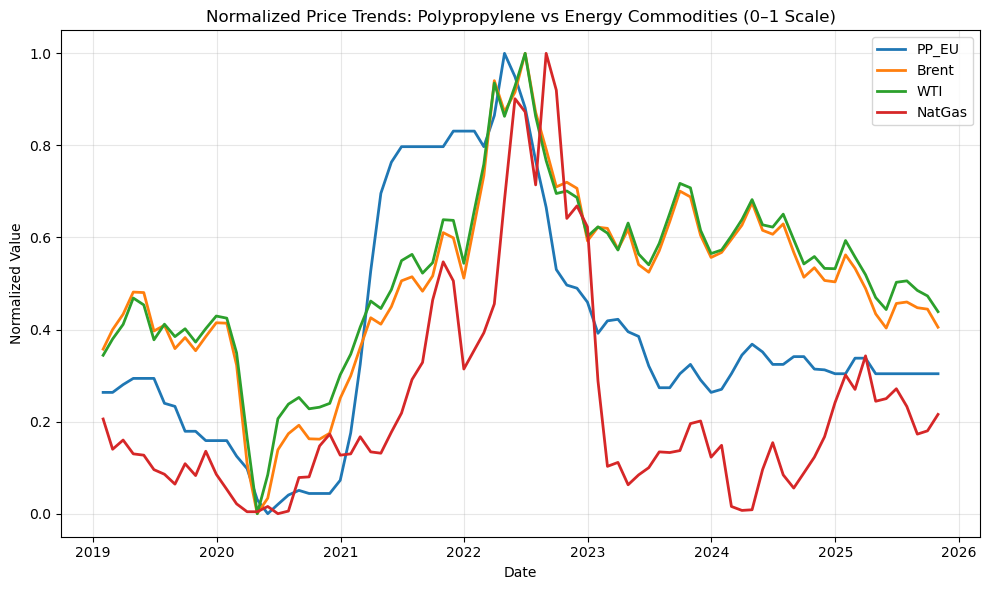

In [11]:
# Normalize each series to 0–1 range
df_norm = (df - df.min()) / (df.max() - df.min())

plt.figure(figsize=(10,6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col, linewidth=2)

plt.title("Normalized Price Trends: Polypropylene vs Energy Commodities (0–1 Scale)")
plt.ylabel("Normalized Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS / 'corr_prices_normalized.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Correlation Analysis
To quantify how strongly the variables move together, we compute Pearson correlation coefficients
between polypropylene, Brent, WTI, and natural gas prices.  
A heatmap helps visualize the direction and strength of these relationships.

In [12]:
corr_matrix = df.corr(method="pearson")
print("Correlation Matrix:\n", corr_matrix.round(3))

# Optional: sort by PP correlation
corr_with_pp = corr_matrix["PP_EU"].sort_values(ascending=False)
print("\nCorrelation of PP_EU with others:\n", corr_with_pp)


Correlation Matrix:
         PP_EU  Brent    WTI  NatGas
PP_EU   1.000  0.722  0.739   0.691
Brent   0.722  1.000  0.994   0.649
WTI     0.739  0.994  1.000   0.649
NatGas  0.691  0.649  0.649   1.000

Correlation of PP_EU with others:
 PP_EU     1.000000
WTI       0.739060
Brent     0.722163
NatGas    0.691232
Name: PP_EU, dtype: float64


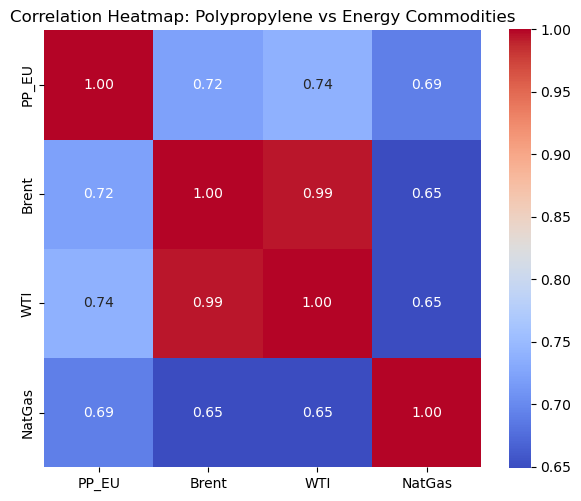

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap: Polypropylene vs Energy Commodities")
plt.tight_layout()
plt.savefig(PLOTS / 'corr_heatmap_pp_energy.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Scatter Plots: Pairwise Relationships
These scatter plots show how Polypropylene (PP) prices relate to Brent, WTI, and Natural Gas prices.
Each point represents one month.  
An upward trend indicates a positive correlation — as energy prices rise, PP prices tend to increase as well.


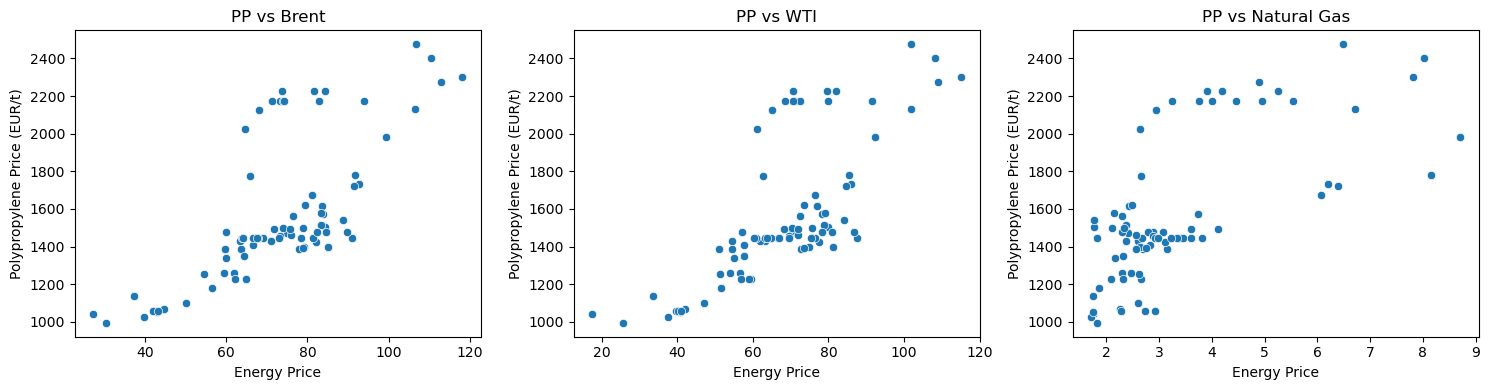

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.scatterplot(x="Brent",  y="PP_EU", data=df, ax=axes[0])
axes[0].set_title("PP vs Brent")

sns.scatterplot(x="WTI",    y="PP_EU", data=df, ax=axes[1])
axes[1].set_title("PP vs WTI")

sns.scatterplot(x="NatGas", y="PP_EU", data=df, ax=axes[2])
axes[2].set_title("PP vs Natural Gas")

for ax in axes:
    ax.set_xlabel("Energy Price")
    ax.set_ylabel("Polypropylene Price (EUR/t)")
plt.tight_layout()
plt.tight_layout()
plt.savefig(PLOTS / 'corr_scatter_pp_vs_energy.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Lagged Correlation (1-Month Delay)
Because polypropylene contracts in Europe are often settled monthly, price adjustments usually reflect
the previous month's feedstock costs.  
Here we create lagged variables (Brent_Lag1, WTI_Lag1, NatGas_Lag1) shifted by one month and measure
how strongly last month’s energy prices correlate with current PP prices.


In [15]:
df_lag = df.copy()
df_lag["Brent_Lag1"] = df_lag["Brent"].shift(1)
df_lag["WTI_Lag1"]   = df_lag["WTI"].shift(1)
df_lag["NatGas_Lag1"]= df_lag["NatGas"].shift(1)

lag_corr = df_lag[["PP_EU","Brent_Lag1","WTI_Lag1","NatGas_Lag1"]].corr().loc["PP_EU"]
print("Lagged Correlations (with 1-month delay):\n", lag_corr)


Lagged Correlations (with 1-month delay):
 PP_EU          1.000000
Brent_Lag1     0.674092
WTI_Lag1       0.696068
NatGas_Lag1    0.621777
Name: PP_EU, dtype: float64


### Interpretation of Lagged Correlations
The lagged correlation results show that:

- **WTI (0.70)** and **Brent (0.67)** have strong positive correlations with PP,
  meaning changes in crude oil prices influence PP with about a one-month delay.
- **Natural Gas (0.62)** also shows a significant delayed relationship,
  reflecting its indirect role in European polypropylene production costs.

These findings align with industry pricing behavior, where monthly polymer settlements follow
the prior month’s movements in feedstock and energy markets.
